In [1]:
library(tidyverse)
library(cowplot)
theme_set(theme_cowplot())
library(ggupset)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

rslt <- '../results/'
detected_palette <- c('Yes' = 'grey80', 'No' = '#e34a33')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




In [2]:
snp_compare <- function(ds) {
    
    wBiofilter <- read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'with Biofilter') %>%
        select(uniq_snp_id, pvalue) %>%
        unique
    
    woBiofilter <- read_csv(paste0(rslt, 'withoutBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'without Biofilter') %>%
        select(uniq_snp_id, pvalue) %>%
        unique

    full_join(wBiofilter, woBiofilter, by = 'uniq_snp_id', suffix = c('_wBiofilter', '_woBiofilter')) %>%
        mutate(where = ds,
               wBiofilter = ifelse(!is.na(pvalue_wBiofilter), 'Yes', 'No'),
               woBiofilter = ifelse(!is.na(pvalue_woBiofilter), 'Yes', 'No'))
    
}

snp_comparison <- bind_rows(snp_compare('Chromatin'),
                            snp_compare('eQTL'),
                            snp_compare('eqtl_chrom'),
                            snp_compare('eqtl_chrom_phys')) %>%
    mutate(where = ifelse(where == 'eqtl_chrom', 'eQTL +\nchromatin', where),
           where = ifelse(where == 'eqtl_chrom_phys', 'eQTL +\nchromatin +\nphysical', where)) %>%
    filter(wBiofilter == 'Yes') %>%
    ggplot(aes(x = where, fill = woBiofilter)) +
        geom_bar() +
        labs(x = 'Protocol', y = 'Significant SNP models', fill = 'Detected\nwithout Biofilter') +
        theme_bw() +
        theme(legend.position = 'bottom') +
        scale_fill_manual(values = detected_palette)

In [3]:
gene_compare <- function(ds) {
    
    wBiofilter <- read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_GenePairs_withoutThreshold.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_snp_id = cbind(SNP1, SNP2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'with Biofilter') %>%
        select(uniq_gene_id, where)
    woBiofilter <- read_csv(paste0(rslt, 'withoutBiofilter_filter/', tolower(ds), '/sign_GenePairs_withoutThreshold.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_snp_id = cbind(SNP1, SNP2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'without Biofilter') %>%
        select(uniq_gene_id, where)

    full_join(wBiofilter, woBiofilter, by = 'uniq_gene_id', suffix = c('_wBiofilter', '_woBiofilter')) %>%
        mutate(ds = ds,
               wBiofilter = ifelse(!is.na(where_wBiofilter), 'Yes', 'No'),
               woBiofilter = ifelse(!is.na(where_woBiofilter), 'Yes', 'No'))
    
}

gene_comparison <- bind_rows(gene_compare('Chromatin'),
                             gene_compare('eQTL'),
                             gene_compare('eqtl_chrom'),
                             gene_compare('eqtl_chrom_phys')) %>%
    mutate(ds = ifelse(ds == 'eqtl_chrom', 'eQTL +\nchromatin', ds),
           ds = ifelse(ds == 'eqtl_chrom_phys', 'eQTL +\nchromatin +\nphysical', ds)) %>%
    filter(wBiofilter == 'Yes') %>%
    ggplot(aes(x = ds, fill = woBiofilter)) +
        geom_bar() +
        labs(x = 'Protocol', y = 'Significant gene models', fill = 'Detected without Biofilter') +
        theme_bw() +
        theme(legend.position = 'none') +
        scale_fill_manual(values = detected_palette)

In [4]:
read_snps <- function(ds) {
    
    read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = ds) %>%
        select(uniq_snp_id, pvalue, where) %>%
        unique
    
}

filter_snp <- bind_rows(read_snps('chromatin'),
                        read_snps('eqtl'),
                        read_snps('eqtl_chrom'),
                        read_snps('eqtl_chrom_phys')) %>%
    group_by(uniq_snp_id) %>%
    summarize(eQTL = 'eqtl' %in% where,
              Chromatin = 'chromatin' %in% where,
              `Chromatin + eQTL` = 'eqtl_chrom' %in% where,
              `Chromatin + eQTL + Physical` = 'eqtl_chrom_phys' %in% where) %>%
    gather(key = 'where', value = 'detected', -uniq_snp_id) %>%
    group_by(uniq_snp_id) %>%
    filter(detected) %>%
    summarize(Protocol = list(where)) %>%
    ggplot(aes(x = Protocol)) +
        geom_bar() +
        scale_x_upset() +
        labs(y = 'Significant SNP models')

In [5]:
read_genes <- function(ds) {
    
    read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_GenePairs_withoutThreshold.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = ds) %>%
        select(uniq_gene_id, where) %>%
        unique
    
}

filter_genes <- bind_rows(read_genes('chromatin'),
                          read_genes('eqtl'),
                          read_genes('eqtl_chrom'),
                          read_genes('eqtl_chrom_phys')) %>%
    group_by(uniq_gene_id) %>%
    summarize(eQTL = 'eqtl' %in% where,
              Chromatin = 'chromatin' %in% where,
              `Chromatin + eQTL` = 'eqtl_chrom' %in% where,
              `Chromatin + eQTL + Physical` = 'eqtl_chrom_phys' %in% where) %>%
    gather(key = 'where', value = 'detected', -uniq_gene_id) %>%
    group_by(uniq_gene_id) %>%
    filter(detected) %>%
    summarize(Protocol = list(where)) %>%
    ggplot(aes(x = Protocol)) +
        geom_bar() +
        scale_x_upset() +
        labs(y = 'Significant gene models')

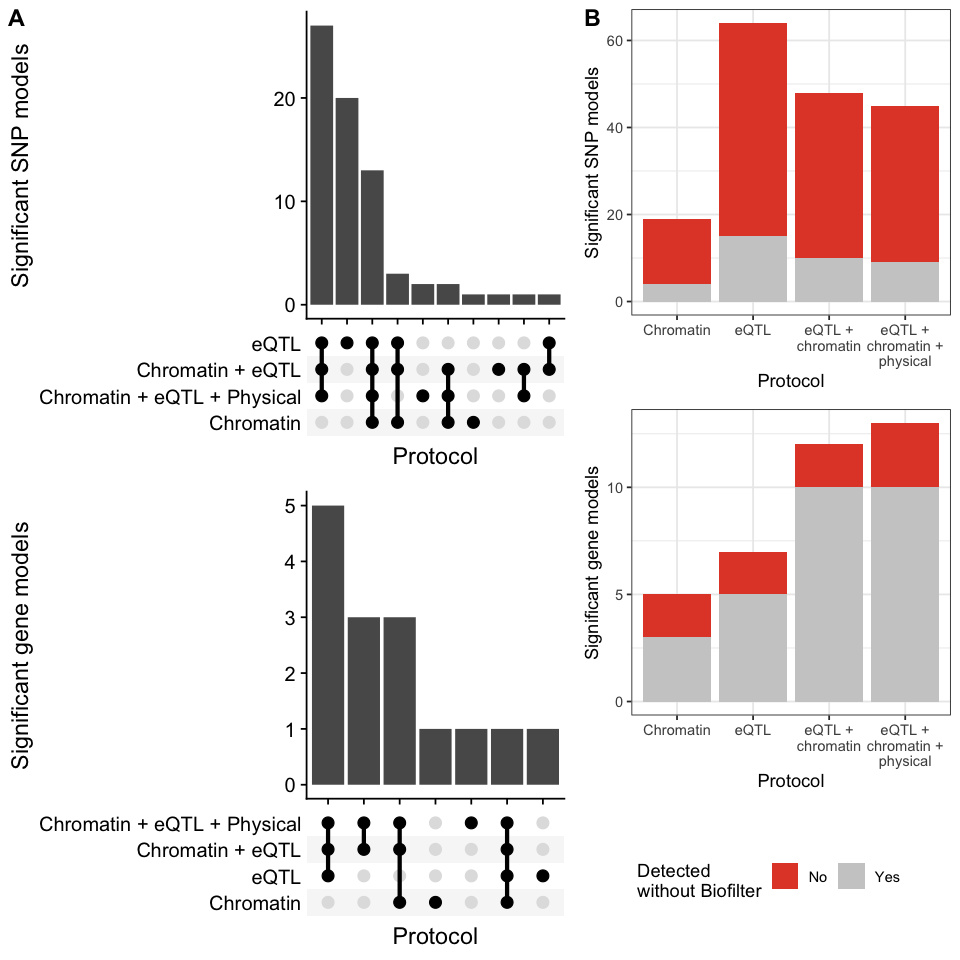

In [7]:
options(repr.plot.width=8, repr.plot.height=8)
plot_grid(plot_grid(filter_snp, filter_genes, nrow = 2),
          plot_grid(plot_grid(snp_comparison + theme(legend.position = 'none'), 
                              gene_comparison, nrow = 2),
                    get_legend(snp_comparison),
                    nrow = 2, rel_heights = c(5,1)),
          ncol = 2, rel_widths = c(1.5,1), labels = c('A','B'))
ggsave(filename = 'fig/superset_comparison.pdf', width=8, height=8, bg = "transparent")

In [22]:
bind_rows(read_snps('chromatin'),
                        read_snps('eqtl'),
                        read_snps('eqtl_chrom'),
                        read_snps('eqtl_chrom_phys')) %>%
    group_by(uniq_snp_id) %>%
    summarize(eQTL = 'eqtl' %in% where,
              Chromatin = 'chromatin' %in% where,
              `Chromatin + eQTL` = 'eqtl_chrom' %in% where,
              `Chromatin + eQTL + Physical` = 'eqtl_chrom_phys' %in% where) %>%
    gather(key = 'where', value = 'detected', -uniq_snp_id) %>%
    group_by(uniq_snp_id) %>%
    filter(detected) %>%
    summarize(Protocol = paste(sort(where), collapse = '_')) %>%
    group_by(Protocol) %>%
    summarize(n = n())

Protocol,n
<chr>,<int>
Chromatin,1
Chromatin + eQTL,1
Chromatin + eQTL + Physical,2
Chromatin + eQTL_Chromatin + eQTL + Physical,1
Chromatin + eQTL_Chromatin + eQTL + Physical_eQTL,27
Chromatin + eQTL_eQTL,1
Chromatin_Chromatin + eQTL_Chromatin + eQTL + Physical,2
Chromatin_Chromatin + eQTL_Chromatin + eQTL + Physical_eQTL,13
Chromatin_Chromatin + eQTL_eQTL,3
